## **Agentic-AI Primer: LLM as Meta-Controller of Reinforcement Learning (RL)**
### A SIMPLE SPEND OPTIMIZATION USE CASE 

WIP Version: 1 <br>
Last Updated:  3/25/2025 <br>
This workbook is the companion code to this <a href="https://decisionsciences.blog/2025/03/31/workbook-agentic-ai-optimize-marketing-spend-with-llm-as-meta-controller-of-learning-environment-part-3/" target="blank">blog post</a> on decisionsciences.blog</br>

***

## Import Libraries: ##

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import langgraph
import os
import sqlite3
from sqlalchemy import create_engine
import requests
import warnings
import optuna
import openai

In [2]:
# colors for plotting
ppt_grey = "#5B738B"
ppt_dark_grey = "#666666"
ppt_medium_grey = "#999999"
ppt_lightgrey = "#CCCCCC"
ppt_blue = "#1B90FF"
ppt_red = "#EE3939"
ppt_rasp = "#FA4F96"
ppt_pink = "#F31DED"

## Set View Options: ##

In [3]:
# turn off warnings
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
#set some options for the output
get_ipython().magic(u'matplotlib inline')
pd.set_option('display.notebook_repr_html', True) 
pd.set_option('display.max_columns', 45) 
pd.set_option('display.max_rows', 40) 
pd.set_option('display.width', 180)
pd.set_option('display.max_colwidth', 240)  # or 199
sns.set_style("whitegrid", {'axes.grid' : False})

## Introduction to the Simple Marketing Spend Optimization Model

This notebook demonstrates a `reinforcement learning (RL)` approach to optimize marketing spend—now enhanced with an `LLM meta-controller`. The meta-controller oversees the RL agent’s iterative process by `initializing the agent, training it, evaluating performance, adjusting environment parameters, and tracking the best results`. In particular, it records the `highest mean per-step reward` observed and the corresponding `recommended spend levels` for each marketing channel.

### Business Overview

Imagine your goal is to determine the `optimal marketing spend` that maximizes net profit. Both the revenue generated and the cost incurred depend on the spend level:
- **Spend:** the marketing budget allocated.
- **Revenue:** modelled as a parabolic function of spend. Revenue increases as spend increases until reaching an optimal level, beyond which it declines.
- **Cost:** directly proportional to spend (with a fixed cost factor of 1.0 for consistency).

The RL agent experiments with different spending strategies. Meanwhile, the `LLM meta-controller iteratively directs this process—by reinitializing the agent, training it, evaluating its performance, and making adjustments`—until the optimal strategy is identified.

### Objective

The objective is to **maximize net profit** by optimizing the spend level. The reward function is defined as follows:

$
\text{Reward} = \text{Revenue}_{ch0} + \text{Revenue}_{ch1} - (\text{spend}_{ch0} + \text{spend}_{ch1})
$

with the revenue for each channel given by:

$
\text{Revenue}_{ch} = -(\text{spend}_{ch} - 5)^2 + 25.
$

At the optimal spend (around 4–5 per channel), each channel yields a net reward of 20, `leading to a maximum per-step reward of 40`. The goal is to have the agent’s mean per-step reward approach this theoretical maximum.

### LLM Meta-Controller and RL Training

In this enhanced scenario, an `LLM acts as a meta-controller`, orchestrating the following tools:
- **init_rl_subpolicy:** initializes or resets the RL agent (using PPO) and the environment.
- **train_subpolicy:** trains the agent for a specified number of timesteps.
- **evaluate_subpolicy:** evaluates the agent over multiple episodes and reports:
  - Cumulative reward and normalized per-step reward.
  - Average final spend per channel.
- **set_env_params:** adjusts environment parameters such as `max_spend` (with the cost factor fixed at 1.0).
- **get_best_score:** retrieves the best (highest) mean per-step reward achieved so far.
- **get_recommended_spends:** returns the recommended spend levels (for each channel) corresponding to the best performance.

### Iterative Process

The `LLM meta-controller` repeatedly:
1. **Initializes** the RL sub-policy.
2. **Trains** the sub-policy.
3. **Evaluates** performance and updates the best mean per-step reward along with the associated spend levels.
4. **Adjusts** environment parameters as needed.
5. **Queries** the best score and recommended spend levels using the dedicated tools.

This `iterative process continues until the agent’s mean per-step reward approaches the optimal value of 40`. The explicit tracking of the best score and the corresponding spend configuration helps guide further adjustments and ensures that the agent is converging toward the desired outcome.

### Reinforcement Learning Training Process

The RL agent interacts with the environment by choosing actions that adjust the spend levels. Over many episodes, it learns to favor actions that yield higher net profit—optimizing its policy through the balance of exploration and exploitation.

By `integrating the LLM meta-controller`, the system not only automates the RL training loop but also provides detailed insights into its progress, including:
- The current best mean per-step reward.
- The recommended final spend levels for each channel based on the best performance observed.

This comprehensive setup allows you to monitor and adjust the optimization process dynamically, ensuring that your model converges toward near-optimal performance.

---

### Understanding the Parabolic Revenue Function:

In our model, revenue follows a `simple parabolic function` that has a peak at a spend value of 5.0, as shown in the following equation:

$
\text{Revenue} = -(s - 5)^2 + 25
$

Where:
- $( s $) is the spend level.
- The revenue decreases as the spend moves further from 5.

This function captures the idea that while higher spending may initially increase revenue, beyond a certain point, the return on investment decreases.

### Why a Parabolic Function?
This model assumes `diminishing returns` on marketing spend, where too much spend leads to inefficiency. For example:
- **Under-spending** may miss opportunities to reach potential customers.
- **Over-spending** leads to inefficient allocation and diminishing returns.

The goal is to find the optimal balance that `maximizes net profit`.


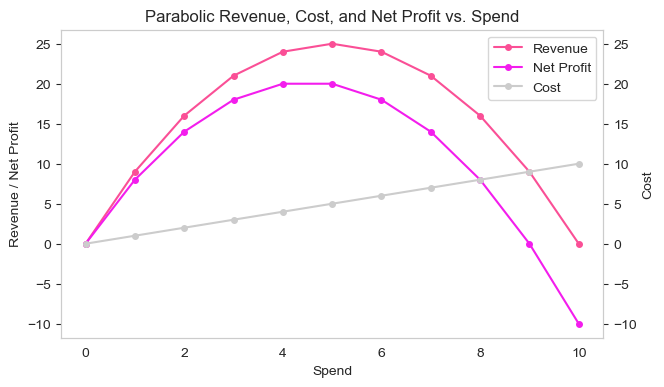

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 1) Generate data
spend_values = np.arange(0, 11, 1)
revenue = -(spend_values - 5)**2 + 25
cost = spend_values * 1.0
net_profit = revenue - cost

# 2) Create the figure and two axes
fig, ax1 = plt.subplots(figsize=(7, 4))

# 'ax2' will share the same x-axis but can have a separate y-axis
ax2 = ax1.twinx()

# 3) Plot revenue and net profit on ax1
lns1 = ax1.plot(spend_values, revenue, label="Revenue", marker='o', markersize=4, color=ppt_rasp)
lns2 = ax1.plot(spend_values, net_profit, label="Net Profit", marker='o', markersize=4, color=ppt_pink)

# 4) Plot cost on ax2
# (Choose a distinct color or re-use your palette as needed)
lns3 = ax2.plot(spend_values, cost, label="Cost", marker='o', markersize=4,color=ppt_lightgrey)

# 5) Force ax2 to match ax1's y-limits so they share the same numeric scale
ax2.set_ylim(ax1.get_ylim())

# 6) Combine legends from both axes
lines = lns1 + lns2 + lns3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="best")

# 7) Label the axes
ax1.set_xlabel("Spend")
ax1.set_ylabel("Revenue / Net Profit")
ax2.set_ylabel("Cost")

# 8) Add title and show
plt.title("Parabolic Revenue, Cost, and Net Profit vs. Spend")
plt.show()

#### What This Plot Shows:
- `Revenue`: peaks at spend = 5 (where it hits 25).
- `Cost`: increases linearly with spend (cost factor = 1.0).
- `Net Profit`: the difference between revenue and cost, reaching its `maximum at spend 4 or 5 (net profit=20)`.

This visualization confirms the `theoretical sweet spot` for spending, which the RL agent should ideally discover through trial and error.

## A. Multi-Channel RL Environment Overview

The `MultiChannelMarketingEnv` is a custom Gymnasium environment that **simulates a marketing scenario with two channels**. In this environment, the agent selects `actions that increment or decrement the marketing spend for each channel`. The reward for each step is calculated as the total revenue minus the total cost. Revenue for each channel is defined by a `parabolic function—peaking at an optimal spend (around 5)`—while the cost is proportional to the total spend.

- **Purpose:**  
  The environment models a **two-channel marketing scenario** where the agent's goal is to optimize spend levels to maximize net profit.
- **Dynamics:**  
  The agent's actions adjust the spend levels; the revenue is computed via a parabolic function with a peak at spend = 5; and the cost is proportional to the total spend.
- **Training Context:**  
  This environment is designed to be used with RL algorithms (such as PPO) where the agent learns an optimal policy to achieve a maximum per-step reward (ideally reaching a theoretical maximum of 40 under ideal conditions).

---

## Detailed Explanation

### 1. Environment Setup

- **Constructor (`__init__`)**
  - **Parameters:**  
    - `max_spend`: Maximum spend allowed per channel (default is 10).
    - `cost_factor`: Multiplier for the cost incurred per unit of spend (default is 1.0).
    - `max_steps`: Maximum number of steps (or interactions) per episode (default is 100).
  - **State and Spaces:**
    - **Observation Space:**  
      The state is a two-dimensional array `[spend_channel0, spend_channel1]` where each spend is in the range `[0, max_spend]`.
    - **Action Space:**  
      There are `9 discrete actions`. Each action corresponds to a change in the spend for both channels. For example, an action might increment one channel while leaving the other unchanged.
  - **Action Map:**  
    A dictionary (`_action_map`) maps action indices (0–8) to tuples that indicate the change (delta) for each channel.

### 2. Seeding and Resetting

- **Seed Function (`seed`):**
  - Sets the random number generator (RNG) for reproducibility. This ensures that the environment's randomness (like the initial spend levels) can be replicated.
- **Reset Function (`reset`):**
  - Resets the environment at the beginning of an episode.
  - Uses the RNG to sample initial spend values for both channels (between 0 and `max_spend`).
  - Resets the step counter to zero.
  - Returns the initial state and an empty info dictionary.

### 3. Step Function (`step`)

- **Action Interpretation:**  
  The function converts the action index into a pair of changes (Δch0, Δch1) using the `_action_map`.
  
- **State Update:**  
  The current spend values for both channels are updated by applying the action's deltas. The updated values are clipped to stay within the bounds `[0, max_spend]`.

- **Revenue Calculation:**  
  For each channel, revenue is calculated as:  
  $
  \text{Revenue}_{ch} = -(\text{spend}_{ch} - 5)^2 + 25
  $ <br>
  This parabolic function means that revenue peaks when the spend is near 5.

- **Cost and Reward:**  
  The total cost is the sum of spends multiplied by the `cost_factor`.  
  The reward is the difference between the total revenue (from both channels) and the total cost.

- **Episode Management:**  
  The step counter is incremented.  
  There’s no terminal condition based on state (i.e., the episode never ends due to reaching an optimal state); instead, episodes are truncated when `max_steps` is reached.

### 4. Render Method

- **Rendering:**  
  The `render` method prints the current step and spend levels for each channel. This is useful for debugging or visualizing the environment’s state during an episode.

---

In [5]:
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding
import numpy as np

class MultiChannelMarketingEnv(gym.Env):
    """
    Two marketing channels, each with spend in [0..max_spend].
    The agent picks an action that increments/decrements each channel's spend.
    Revenue is the sum of parabolas from each channel; cost is the sum of spends.
    Reward = total_revenue - total_cost.
    """

    def __init__(self, max_spend=10, cost_factor=1.0, max_steps=100):
        super().__init__()
        self.n_channels = 2
        self.max_spend = max_spend
        self.cost_factor = cost_factor
        self.max_steps = max_steps

        # State: [spend_channel0, spend_channel1]
        low = np.array([0, 0], dtype=np.float32)
        high = np.array([float(max_spend), float(max_spend)], dtype=np.float32)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)

        # Define 9 discrete actions: mapping indices to (Δch0, Δch1)
        self.action_space = spaces.Discrete(9)
        self._action_map = {
            0: ( 0,  0),
            1: (+1,  0),
            2: (-1,  0),
            3: ( 0, +1),
            4: ( 0, -1),
            5: (+1, +1),
            6: (+1, -1),
            7: (-1, +1),
            8: (-1, -1),
        }

        self.state = None
        self.current_step = 0
        self.seed()  # Initialize the random generator

    def seed(self, seed=None):
        """Sets the seed for the environment's RNG."""
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self, seed=None, options=None):
        # Reseed if a new seed is provided
        if seed is not None:
            self.seed(seed)
        self.current_step = 0
        # Use the environment's RNG to sample initial spend for each channel
        ch0 = self.np_random.integers(0, self.max_spend + 1)
        ch1 = self.np_random.integers(0, self.max_spend + 1)
        self.state = np.array([float(ch0), float(ch1)], dtype=np.float32)
        return self.state, {}  # Return (observation, info)

    def step(self, action):
        # Convert action index to (Δch0, Δch1)
        delta_ch0, delta_ch1 = self._action_map[action]
        ch0, ch1 = self.state
        ch0 = np.clip(ch0 + delta_ch0, 0, self.max_spend)
        ch1 = np.clip(ch1 + delta_ch1, 0, self.max_spend)

        # Calculate revenue using parabolic functions for each channel
        rev_ch0 = -(ch0 - 5) ** 2 + 25
        rev_ch1 = -(ch1 - 5) ** 2 + 25
        total_revenue = rev_ch0 + rev_ch1

        # Calculate cost and reward
        cost = (ch0 + ch1) * self.cost_factor
        reward = total_revenue - cost

        # Update the state and step count
        self.state = np.array([ch0, ch1], dtype=np.float32)
        self.current_step += 1

        terminated = False  # No terminal condition here
        truncated = self.current_step >= self.max_steps  # Episode is truncated when max steps reached
        info = {}
        return self.state, reward, terminated, truncated, info

    def render(self):
        ch0, ch1 = self.state
        print(f"Step {self.current_step}, Channel0={ch0}, Channel1={ch1}")


## B. LLM Meta-Controller Tools: Helper Functions for RL Sub-Policy Management and Best Score Tracking

#### Global Variables for Tracking Performance

- **`best_mean_reward` & `best_spend_levels`:**  
  These global variables store the highest mean per-step reward observed so far and the corresponding average spend levels (one for each marketing channel). This lets the system remember the best configuration found during training.

#### Helper Functions for Score Tracking

- **`update_best_score(current_mean_reward, spend_levels)`:**  
  Checks if the current mean reward is higher than the best observed so far. If so, it updates both `best_mean_reward` and `best_spend_levels`. It returns a message indicating the updated best score.

- **`get_best_score()`:**  
  Returns a formatted string with the current best mean per-step reward.

- **`get_recommended_spends()` & `get_recommended_spends_tool(args)`:**  
  These functions return the spend levels (for channel 0 and channel 1) that correspond to the best score. The tool wrapper (`get_recommended_spends_tool`) is provided so that the LLM can call it as one of its available tools.

#### Global References to the Model and Environment

- **`env` and `model`:**  
  These global variables store the current instance of the marketing environment and the PPO model. They are updated by the various tools as needed.

#### Tools for Managing the RL Sub-Policy

- **`init_rl_subpolicy_tool(args)`:**  
  Initializes (or resets) the RL sub-policy by creating a new instance of the marketing environment and a PPO model with default parameters. Although `args` could be used to pass in custom settings, in this version it uses defaults (max_spend=10, cost_factor=1.0, max_steps=100).

- **`train_subpolicy_tool(args)`:**  
  Trains the PPO model for a specified number of timesteps and optionally updates the learning rate. The function parses parameters (e.g., "timesteps=5000, lr=0.0005") from the input string and runs the model's learning routine.

- **`evaluate_subpolicy_tool(_input)`:**  
  Evaluates the current PPO model over several episodes. It:
  - Computes the cumulative reward and normalizes it to obtain the mean per-step reward.
  - Runs several episodes manually to collect the final spend levels for each channel.
  - Averages the spend values across episodes.
  - Calls `update_best_score` to update the best score (and its corresponding spend levels) if the current evaluation is an improvement.
  - Returns a detailed report including cumulative reward, mean per-step reward (with its standard deviation), average spend levels, and an update message on the best score.

- **`set_env_params_tool(args)`:**  
  Reinstantiates the environment with new parameters. In this version, it only parses the `max_spend` parameter from the input (ignoring any cost factor changes by always fixing `cost_factor=1.0`). This tool lets the meta-controller adjust the environment without altering the cost factor.

---

### Overall Role in the Meta-Controller

These helper functions are intended to be exposed to the LLM as tools. The meta-controller can call these functions in its iterative process:
- **Initialization:**  
  It begins by calling `init_rl_subpolicy_tool` to set up the RL sub-policy.
- **Training:**  
  It trains the model via `train_subpolicy_tool`.
- **Evaluation:**  
  It assesses performance using `evaluate_subpolicy_tool`, which also updates the best observed performance.
- **Parameter Adjustment:**  
  If needed, it adjusts the environment using `set_env_params_tool`.
- **Retrieval of Best Results:**  
  The LLM can query the best score (`get_best_score`) and recommended spend levels (`get_recommended_spends_tool`) to decide on further actions.

This modular design allows the LLM meta-controller to systematically manage the RL training process and ensure that it tracks key performance metrics and configurations throughout its iterations.

In [6]:
##############################################
# RL Sub-Policy: Global Model and Helper Functions (Tools for LLM)
##############################################

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

# Global variables for tracking best performance and the corresponding spend levels.
best_mean_reward = -float('inf')
best_spend_levels = None  # This will hold a tuple like (avg_spend_channel0, avg_spend_channel1)

def update_best_score(current_mean_reward: float, spend_levels: list) -> str:
    global best_mean_reward, best_spend_levels
    if current_mean_reward > best_mean_reward:
        best_mean_reward = current_mean_reward
        best_spend_levels = spend_levels  # spend_levels should be a list or tuple [channel0, channel1]
    return f"Updated best mean per-step reward: {best_mean_reward:.2f}"

def get_best_score() -> str:
    """
    Return the current best mean per-step reward.
    """
    return f"Current best mean per-step reward: {best_mean_reward:.2f}"

def get_recommended_spends() -> str:
    global best_spend_levels
    if best_spend_levels is None:
        return "No recommended spend levels available yet."
    else:
        return f"Recommended spend levels: Channel 0 = {best_spend_levels[0]:.2f}, Channel 1 = {best_spend_levels[1]:.2f}"

def get_recommended_spends_tool(args: str) -> str:
    return get_recommended_spends()


# We'll keep a global reference to a PPO model and environment
env = None
model = None

def init_rl_subpolicy_tool(args: str) -> str:
    """
    Create or re-create the environment and the PPO model with default hyperparams.
    'args' could let the LLM pass in environment parameters if desired.
    """
    global env, model

    # Parse arguments from the LLM if you want (like cost_factor=..., max_spend=..., etc.)
    # For simplicity, we'll ignore 'args' here
    env = MultiChannelMarketingEnv(max_spend=10, cost_factor=1.0, max_steps=100)
    model = PPO("MlpPolicy", env, verbose=0)
    return "Initialized RL sub-policy with default PPO."

def train_subpolicy_tool(args: str) -> str:
    global model

    # Default parameters
    timesteps = 5000
    new_lr = None

    for item in args.split(","):
        item = item.strip()
        if item.startswith("timesteps="):
            timesteps = int(item.split("=")[1].strip())
        elif item.startswith("lr="):
            # Remove extra quotes if present
            lr_value = item.split("=")[1].strip().strip("'\"")
            new_lr = float(lr_value)

    if new_lr is not None:
        model.learning_rate = new_lr

    model.learn(total_timesteps=timesteps)
    return f"Trained sub-policy for {timesteps} timesteps (lr={new_lr if new_lr else model.learning_rate})."

def evaluate_subpolicy_tool(_input: str) -> str:
    """
    Evaluate the current PPO model on a few episodes, returning the cumulative reward,
    the normalized per-step reward, the average final spend per channel, and updates the best score.
    """
    global model, env
    from stable_baselines3.common.evaluation import evaluate_policy
    import numpy as np

    # Evaluate the model over several episodes (cumulative rewards are returned)
    cumulative_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=5, deterministic=True)
    
    # Normalize by dividing by the number of steps per episode
    per_step_reward = cumulative_reward / env.max_steps
    per_step_std = std_reward / env.max_steps

    # Run episodes manually to record the final spend levels for each channel
    spends = []
    n_eval = 5
    for _ in range(n_eval):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            if isinstance(action, np.ndarray):
                action = int(action.item())
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
        spends.append(obs)  # Final spend values for this episode
    spends = np.array(spends)
    avg_spend_channel0 = np.mean(spends[:, 0])
    avg_spend_channel1 = np.mean(spends[:, 1])
    
    # Update best score and record spend levels if improved.
    best_score_update = update_best_score(per_step_reward, [avg_spend_channel0, avg_spend_channel1])

    return (
        f"Mean cumulative reward = {cumulative_reward:.2f} +/- {std_reward:.2f}\n"
        f"Mean per-step reward = {per_step_reward:.2f} +/- {per_step_std:.2f} (max per-step = 40)\n"
        f"Average final spend: Channel 0 = {avg_spend_channel0:.2f}, Channel 1 = {avg_spend_channel1:.2f}\n"
        f"{best_score_update}"
    )


def set_env_params_tool(args: str) -> str:
    """
    Re-instantiate the environment with new parameters.
    This version always uses a cost_factor of 1.
    """
    global env, model
    cost_factor = 1.0  # Always fixed to 1
    max_spend = 10     # Default value

    # Only parse max_spend from the input
    for item in args.split(","):
        item = item.strip()
        if item.startswith("max_spend="):
            try:
                provided_value = float(item.split("=")[1])
                # Ensure max_spend is between 0 and 10
                max_spend = int(min(max(provided_value, 0), 10))
            except:
                max_spend = 10

    env = MultiChannelMarketingEnv(max_spend=max_spend, cost_factor=cost_factor, max_steps=100)
    model = PPO("MlpPolicy", env, verbose=0)
    return f"Environment reset with cost_factor={cost_factor}, max_spend={max_spend}."

**Suite of LangChain Tools:**

This code below defines a list of `LangChain tools` that the `LLM meta-controller` uses to manage the RL sub-policy training and optimization process. Each Tool has `attributes like name, func, and description that the LLM meta-controller uses to identify and call the appropriate function`. Tools allow the meta-controller to initialize and train the PPO model, evaluate its performance (while tracking key metrics like the mean per-step reward and recommended spend levels), adjust environment parameters, and retrieve the best observed performance. This modular design enables dynamic and iterative control over the RL training process.

In [7]:
from langchain.tools import Tool

def get_best_score_tool(args: str) -> str:
    return get_best_score()  # Assumes get_best_score() returns a string with the best score

tools = [
    Tool(
        name="init_rl_subpolicy",
        func=init_rl_subpolicy_tool,
        description="Initialize or reset the RL sub-policy (PPO)."
    ),
    Tool(
        name="train_subpolicy",
        func=train_subpolicy_tool,
        description="Train the PPO model for some timesteps, e.g. 'train_subpolicy: timesteps=5000, lr=0.0003'."
    ),
    Tool(
        name="evaluate_subpolicy",
        func=evaluate_subpolicy_tool,
        description="Evaluate the PPO model on a few episodes and return mean reward and spend levels."
    ),
    Tool(
        name="set_env_params",
        func=set_env_params_tool,
        description="Change environment parameters (max_spend, cost_factor), which re-creates the environment."
    ),
    Tool(
        name="get_best_score",
        func=get_best_score_tool,  # assuming you defined this earlier
        description="Retrieve the current best mean per-step reward achieved so far."
    ),
    Tool(
        name="get_recommended_spends",
        func=get_recommended_spends_tool,
        description="Retrieve the final recommended spend levels for each channel based on the best evaluation."
    ),
]


## C. LLM Meta-Controller Agent Initialization and Configuration

This code block below sets up an LLM-based meta-controller agent that uses `GPT-3.5 Turbo` to `orchestrate a reinforcement learning training process`. By combining a `language model` with a set of `specialized tools` and a `persistent memory`of past interactions, the agent is able to `iteratively control the RL sub-policy`, making adjustments based on performance feedback. The configuration ensures deterministic output (with temperature 0), detailed logging (with verbose mode), and a safeguard against infinite loops (via `max_iterations=100`).

### Overview

1. **Imports and Memory Setup:**
   - **Imports:**
     - `ChatOpenAI` from `langchain_openai`: This class is used to instantiate an LLM using OpenAI's GPT-3.5 Turbo.
     - `AgentType` and `initialize_agent` from `langchain.agents`: These are used to set up the agent, including its type and configuration.
     - `ConversationBufferMemory` from `langchain.memory`: This is a memory class that stores the conversation history (the chain-of-thought) so that the agent can refer back to previous interactions.
   - **Memory Object:**
     - The code creates a `ConversationBufferMemory` object with a key `"chat_history"`. This memory persists the conversation, allowing the agent to remember previous instructions and results throughout its iterations.
<br>&nbsp;
2. **LLM Instantiation:**
   - The agent uses a ChatOpenAI instance, configured with:
     - **Temperature:** Set to 0 for deterministic output (i.e., less randomness).
     - **Model Name:** Specified as `"gpt-3.5-turbo"`.
   - This LLM is the core language model that will generate responses, reason through the meta-controller's chain-of-thought, and decide which tools to call.
<br>&nbsp;
3. **Agent Initialization:**
   - **`initialize_agent` Function:**
     - The agent is initialized with several key parameters:
       - **`tools`:** The list of tools (functions) that the agent can invoke to manage the RL sub-policy. These include functions for initialization, training, evaluation, environment parameter adjustments, and retrieval of best scores.
       - **`llm`:** The instantiated language model (`ChatOpenAI`) that provides the reasoning and decision-making.
       - **`memory`:** The conversation memory object that stores the history.
       - **`agent`:** The type is set to `AgentType.ZERO_SHOT_REACT_DESCRIPTION`. This type directs the agent to use a zero-shot chain-of-thought reasoning approach, where it reacts to the prompt and tool descriptions without additional training.
       - **`verbose`:** Set to `True` to output detailed logs during the agent’s operation, which is useful for debugging and understanding its internal decision-making process.
       - **`handle_parsing_errors`:** This flag is set to `True` so that any errors encountered during tool invocation are gracefully handled.
       - **`max_iterations`:** Set to `100` to limit the number of iterations the agent can perform before stopping. This prevents endless loops during experimentation.<br>&nbsp; 
4. **Role in the System:**
   - This agent acts as the meta-controller that oversees the entire RL training process.
   - It leverages the provided tools to:
     - Initialize or reset the RL sub-policy.
     - Train the model over a specified number of timesteps.
     - Evaluate the performance and update the best observed metrics.
     - Adjust environment parameters as needed.
   - The meta-controller uses the conversation memory to maintain context across iterations, ensuring that its decisions are informed by previous interactions.

---

In [8]:
# hide langchain depreciation warning 
import warnings
warnings.filterwarnings('ignore')

############################################
# Create an LLM Agent as Meta-Controller
############################################
from langchain_openai import ChatOpenAI
from langchain.agents import AgentType, initialize_agent
from langchain.memory import ConversationBufferMemory

# Create a memory object that stores all conversation history
memory = ConversationBufferMemory(memory_key="chat_history")


llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")

agent = initialize_agent(
    tools=tools,
    llm=llm,
    memory=memory,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations=100 
)


## D. Meta-Controller Prompt: Iterative Optimization Instructions for the RL Sub-Policy

### Overview:

The code below `defines the prompt that the LLM meta-controller uses to guide its iterative process` of optimizing the RL sub-policy. Here’s a breakdown of what’s happening:

1. **Prompt Definition:**
   - A multi-line string is created to serve as the prompt. This prompt instructs the LLM to act as a meta-controller responsible for optimizing a PPO sub-policy in a marketing spend environment.
   - It lists the available tools (such as initializing, training, evaluating, adjusting environment parameters, and retrieving the best scores and recommended spend levels). These tools enable the meta-controller to interact with the RL system.
<br>&nbsp; 
2. **Objective and Iterative Process:**
   - **Objective:**  
     The goal is to achieve an optimal mean per-step reward of 40 (the theoretical maximum) and to determine the final recommended spend levels for each marketing channel.
   - **Process:**  
     The meta-controller must iteratively:
     1. Initialize the RL sub-policy.
     2. Train the PPO model.
     3. Evaluate the PPO model.
     4. Optionally adjust the environment parameters.
   - These steps should be repeated until the target mean per-step reward is reached.
<br>&nbsp; 
3. **Tracking and Reporting:**
   - The prompt instructs the meta-controller to record the highest mean per-step reward observed along with its corresponding spend levels. This is accomplished using the `get_best_score` and `get_recommended_spends` tools.
   - It also mandates that the iteration continues for at least 100 iterations, ensuring that the process is sufficiently thorough.
   - Finally, when the agent stops iterating, it should report the best achieved mean per-step reward and the recommended spend levels, and provide a detailed explanation for why it decided to stop, including an interpretation of the final results.
<br>&nbsp; 
4. **Agent Invocation:**
   - The prompt is passed to the meta-controller agent using `agent.invoke(prompt)`, and the final output is retrieved and printed. This output should include the agent’s final decision, metrics, and reasoning behind stopping.

In summary, this section sets up the high-level control instructions for the LLM meta-controller, detailing both the iterative steps for optimizing the RL sub-policy and the criteria for stopping, while also ensuring that the best performance metrics are tracked and reported.

In [9]:
###########################################
# Prompt the LLM for meta-level control
###########################################
prompt = """
You are an AI meta-controller overseeing a Reinforcement Learning (RL) PPO sub-policy that optimizes marketing spend.
You have access to the following tools:
 - init_rl_subpolicy: Reinitialize the PPO model.
 - train_subpolicy: Train the PPO model for a given number of timesteps (e.g., 'train_subpolicy: timesteps=5000, lr=0.0005').
 - evaluate_subpolicy: Evaluate the PPO model over 5 episodes and return the mean reward.
 - set_env_params: Adjust environment parameters such as cost_factor or max_spend.
 - get_best_score: Retrieve the current best mean per-step reward.
 - get_recommended_spends: Retrieve the recommended spend levels for each channel corresponding to the best score.

Goal: Achieve the optimal mean per-step reward of 40 (the maximum achievable per-step reward), and determine the final recommended spend levels for each channel.
You must iteratively:
1) Initialize the RL sub-policy.
2) Train the PPO model.
3) Evaluate the PPO model.
4) Optionally adjust environment parameters.

Repeat steps 2 through 4 until the mean per-step reward reaches 40.
As you iterate, record the highest mean per-step reward you have encountered along with its corresponding spend levels. Use the get_best_score and get_recommended_spends tools to keep track of these values.
Do not stop iterating until you have completed at least 100 iterations, regardless of intermediate performance.
Report the best result for mean per-step reward and corresponding spend levels when providing your final reponse. 
Explain why you decided to stop when you did when giving your final response and provide a detailed interpretation of the final results.
"""

response = agent.invoke(prompt)
final_text = response.get("output", "")
print("\nFinal Agent Response:\n", final_text)



> Entering new AgentExecutor chain...
I need to follow the iterative process of training, evaluating, and potentially adjusting environment parameters to optimize the mean per-step reward to 40. I should keep track of the best mean per-step reward and corresponding spend levels throughout the iterations.

Action: init_rl_subpolicy
Action Input: None
Observation: Initialized RL sub-policy with default PPO.
The RL sub-policy has been initialized, now I can proceed with training.

Action: train_subpolicy
Action Input: timesteps=5000, lr=0.0005
Observation: Trained sub-policy for 5000 timesteps (lr=0.0005).
The sub-policy has been trained, now I need to evaluate its performance.

Action: evaluate_subpolicy
Action Input: None
Observation: Mean cumulative reward = 2030.80 +/- 612.05
Mean per-step reward = 20.31 +/- 6.12 (max per-step = 40)
Average final spend: Channel 0 = 1.80, Channel 1 = 1.20
Updated best mean per-step reward: 20.31
The mean per-step reward is 20.31, which is not yet opt

## E. Interpreting the Meta-Controller Readout: A Step-by-Step Breakdown

Below is a high-level breakdown to help you interpret the readout above:

- **AgentExecutor Chain Initiation:**  
  The readout begins by stating that a new agent chain is starting. This indicates that the LLM meta-controller is entering its iterative decision process.
<br>&nbsp; 
- **Thought, Action, Observation Structure:**  
  The output is organized into a sequence of:
  - **Thought:** The meta-controller's `internal reasoning or explanation` (e.g., "I need to follow the iterative process...").
  - **Action:** The `specific tool it decides to invoke` (e.g., `init_rl_subpolicy`, `train_subpolicy`, `evaluate_subpolicy`, or `set_env_params`).
  - **Action Input:** Any `parameters or arguments` provided to the tool.
  - **Observation:** The `output received from the tool call`. This includes performance metrics like cumulative reward, mean per-step reward, and average final spend for each channel.
<br>&nbsp; 
- **Iterative Process:**  
  The meta-controller repeatedly:
  - **Initializes or trains the sub-policy** (with `init_rl_subpolicy` or `train_subpolicy`).
  - **Evaluates its performance** (with `evaluate_subpolicy`), where the readout shows updated metrics.
  - **Optionally adjusts environment parameters** (with `set_env_params`) to see if changes improve performance.
  - **Tracks the best performance:**  
    It updates the best mean per-step reward and logs the corresponding recommended spend levels using helper functions.
<br>&nbsp; 
- **Final Decision and Explanation:**  
  At the end of the chain, the meta-controller provides a final answer that includes:
  - The `best mean per-step reward` achieved (without referencing specific numbers, just that it’s close to the optimal value).
  - The `recommended spend levels` for each channel corresponding to that best performance.
  - An `explanation of why it decided to stop iterating`—typically noting that performance improvements have plateaued, or that further iterations may risk overfitting or be less cost-effective.
<br>&nbsp; 
This structured output lets you see not only the final metrics but also `how the agent’s internal reasoning evolved over the iterations`, the sequence of tool invocations, and the rationale behind its final decision.